---
### Closed-Form Solution with Michaelis-Menten Kinetics

Solve for lambda and Y with built-in Python library

In [161]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from joblib import Parallel, delayed
import pandas as pd
import time

# Constants
a = 23.8
k = 0.01
N = 100
# b_min, b_max, b_large = 5e-6, 0.001, False
b_min, b_max, b_large = 5e7, 1e8, True
b_vals = np.logspace(np.log10(b_min), np.log10(b_max), N)
#b_vals = np.linspace(b_min, b_max, N+1)

### Softmax transformation

In [162]:
from scipy.special import logsumexp
def softmax_partition(u):
    u_val = float(u)
    logZ = logsumexp([u_val, 0.0])
    theta1 = np.exp(u_val - logZ)
    theta2 = np.exp(-logZ)
    return theta1, theta2

# System
def BioSystemMM2(theta, b_val):
    term_Y1 = (a * theta[1]) / (b_val * theta[0]) + k - 1
    Y1 = 0.5 * (np.sqrt(term_Y1**2 + 4 * k) - term_Y1)
    Y2 = (a * theta[1] / b_val) * (Y1 / (k + Y1))
    Y3 = 1 - Y1 - Y2
    lambda_val = b_val * Y2
    return np.array([b_val, theta[0], theta[1], Y1, Y2, Y3, lambda_val])

def objective_softmax(u, b_val): return -BioSystemMM2(softmax_partition(u), b_val)[6]   # objective function

# Optimization
def optimize_for_b_softmax(b_val, tol=1e-6, gtol=1e-8, maxiter=2000):
    if b_large:
        result = minimize(
            lambda u: objective_softmax(u, b_val),
            x0=0.0,
            bounds=[(-10, 10)],
            method='L-BFGS-B',   # L-BFGS-B has bounds
            tol=tol,
            options={
                'gtol': gtol,
                'maxiter': maxiter,
                'disp': False
            }
        )
    else:
        result = minimize(
            lambda u: objective_softmax(u, b_val),
            x0=0.0,
            method='Powell',   # derivative-free method
            tol=tol,
            options={
                'maxiter': maxiter,
                'disp': False
            }
        )
    if result.success or (np.abs(result.fun) < 1e-6):
        bio_result = BioSystemMM2(softmax_partition(result.x), b_val)
        lambda_max_expected = b_val * 1.0  # lambda = b*Y2, and Y2 <= 1
        if (bio_result[6] >= 0 and bio_result[6] <= lambda_max_expected):
            return bio_result
    return None


# Parallel execution
start = time.time()
results = Parallel(n_jobs=-1)(delayed(optimize_for_b_softmax)(b) for b in b_vals)
results = np.array([r for r in results if r is not None])
print(f"Optimization completed in {time.time() - start:.2f} seconds.")

(b_arr, theta1_arr, theta2_arr, Y1_arr, Y2_arr, Y3_arr, lambda_arr) = results.T   # The "Pythonic" way using tuple unpacking!

Optimization completed in 0.12 seconds.


### Line fitting

In [163]:
from scipy.stats import linregress
# Perform linear regression
def linear_fit(x, y):
  slope, intercept, r_value, p_value, std_err = linregress(x, y)
  x_fit = np.linspace(min(x), max(x), 201)
  y_fit = slope * x_fit + intercept
  r_squared = r_value**2
  return [x_fit, y_fit, r_squared, slope, intercept]

# lambda vs. b (linear)
b_lambda_fit = linear_fit(b_arr, lambda_arr)
Y2_lambda_fit = linear_fit(Y2_arr, lambda_arr)
Y3_lambda_fit = linear_fit(Y3_arr, lambda_arr)

### Plot the result

,Nutrient level,Growth rate,Y1,Y2,Y3,Sum_Y,Approx. Sum_Y
0,5.000000e+07,23.561126,0.993148,4.712225e-07,0.006851,1.0,None
1,5.035130e+07,23.561138,0.993172,4.679350e-07,0.006827,1.0,None
2,5.070507e+07,23.561149,0.993194,4.646704e-07,0.006805,1.0,None
3,5.106133e+07,23.561160,0.993219,4.614286e-07,0.006780,1.0,None
4,5.142009e+07,23.561171,0.993242,4.582095e-07,0.006757,1.0,None
...,...,...,...,...,...,...,...
95,9.723826e+07,23.562042,0.995082,2.423125e-07,0.004918,1.0,None
96,9.792146e+07,23.562051,0.995099,2.406219e-07,0.004900,1.0,None
97,9.860946e+07,23.562059,0.995116,2.389432e-07,0.004883,1.0,None
98,9.930230e+07,23.562067,0.995132,2.372762e-07,0.004868,1.0,None


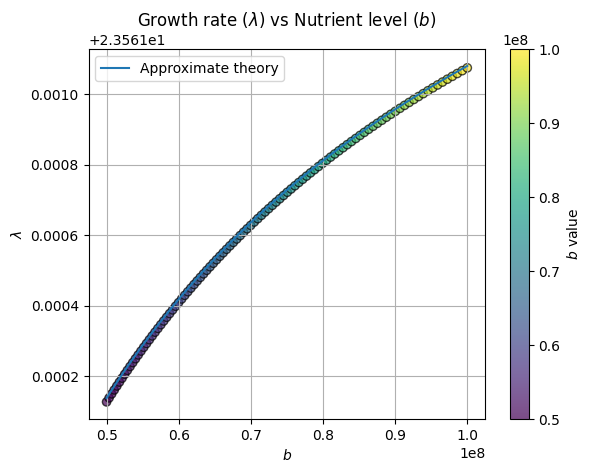

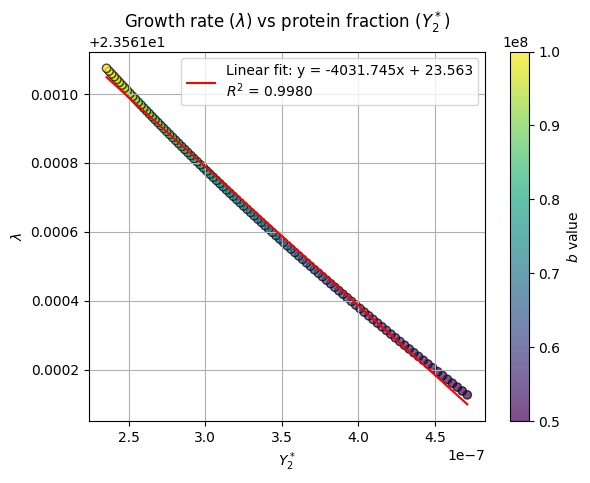

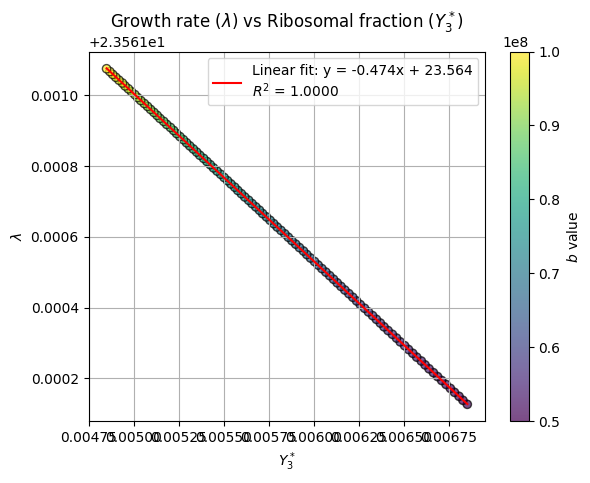

In [164]:
# Put in DataFrame
df = pd.DataFrame({
    "Nutrient level": b_arr,
    "Growth rate": lambda_arr,
    "Y1": Y1_arr,
    "Y2": Y2_arr,
    "Y3": Y3_arr,
    "Sum_Y": Y1_arr + Y2_arr + Y3_arr,
    "Approx. Sum_Y": None
})
display(df)

# Growth rate to nutrient level (b)
if b_large:
    lambda_approx_arr = (a/(1+k)) - (2*a*np.sqrt(k)/(1+k)**2)*np.sqrt(a/b_arr) + (2*k/(1+k)**3)*(a**2/b_arr)
else:
    lambda_approx_arr = b_arr - 2*np.sqrt(k/a) * b_arr**(3/2) - ((1-2*k)/a)*b_arr**2

plt.figure()
scatter = plt.scatter(b_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.plot(b_arr, lambda_approx_arr, '-', label='Approximate theory')
plt.xlabel(r'$b$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs Nutrient level ($b$)')
plt.legend()
plt.grid(True)
plt.show()

# Growth rate to protein fraction (Y2)
plt.figure()
scatter = plt.scatter(Y2_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.plot(Y2_lambda_fit[0], Y2_lambda_fit[1], '-', label=f'Linear fit: y = {Y2_lambda_fit[3]:.3f}x + {Y2_lambda_fit[4]:.3f}\n$R^2$ = {Y2_lambda_fit[2]:.4f}', color='red') # line of best fit
plt.xlabel(r'$Y_2^*$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs protein fraction ($Y_2^*$)')
plt.grid(True)
plt.legend()
plt.show()

# Growth rate to ribosomal fraction (Y3)
plt.figure()
scatter = plt.scatter(Y3_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.plot(Y3_lambda_fit[0], Y3_lambda_fit[1], '-', 
label=f'Linear fit: y = {Y3_lambda_fit[3]:.3f}x + {Y3_lambda_fit[4]:.3f}\n$R^2$ = {Y3_lambda_fit[2]:.4f}', color='red')
plt.xlabel(r'$Y_3^*$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs Ribosomal fraction ($Y_3^*$)')
plt.grid(True)
plt.legend()
plt.show()

Data saved to PP2_MM_output.csv (100 rows)


,Nutrient level,Growth rate,$\theta_1$,$\theta_2$,$p = \frac{\theta_2}{\theta_1}$,$\sum \theta$,Approx. $\sum \theta$
0,5.000000e+07,23.561126,0.000069,0.999931,14539.467986,1.0,1.0
1,5.035130e+07,23.561138,0.000069,0.999931,14590.141128,1.0,1.0
2,5.070507e+07,23.561149,0.000068,0.999932,14645.717149,1.0,1.0
3,5.106133e+07,23.561160,0.000068,0.999932,14693.800804,1.0,1.0
4,5.142009e+07,23.561171,0.000068,0.999932,14747.497066,1.0,1.0
5,5.178137e+07,23.561183,0.000068,0.999932,14798.323271,1.0,1.0
6,5.214519e+07,23.561194,0.000067,0.999933,14848.642976,1.0,1.0
7,5.251156e+07,23.561205,0.000067,0.999933,14901.628101,1.0,1.0
8,5.288051e+07,23.561216,0.000067,0.999933,14954.846415,1.0,1.0
9,5.325205e+07,23.561227,0.000067,0.999933,15004.914213,1.0,1.0


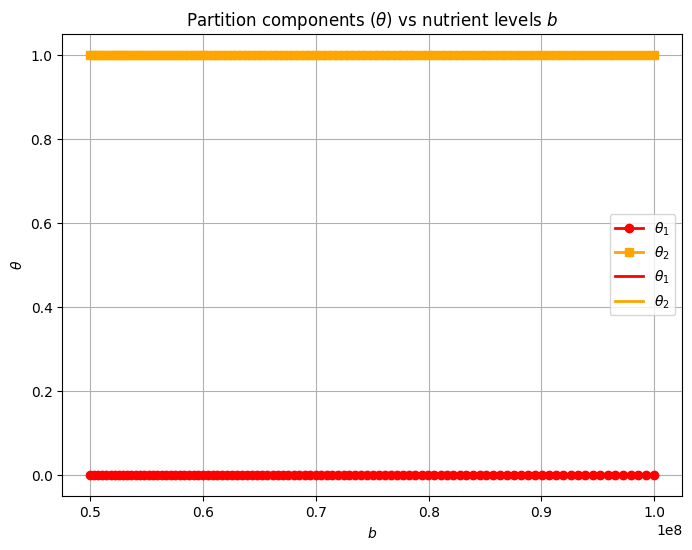

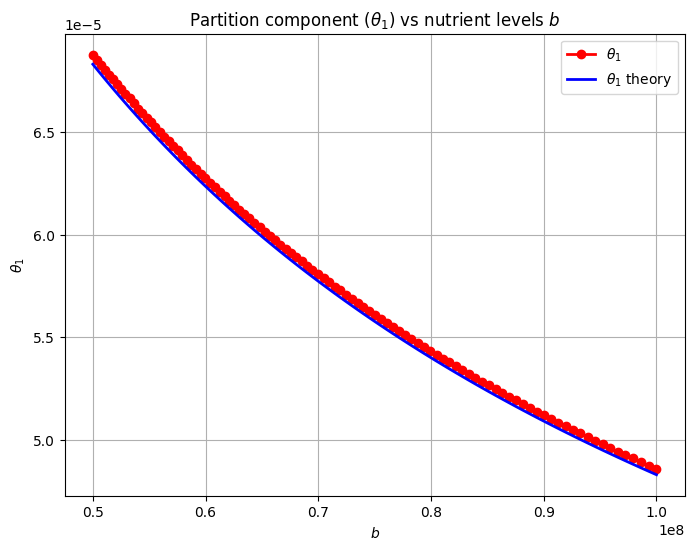

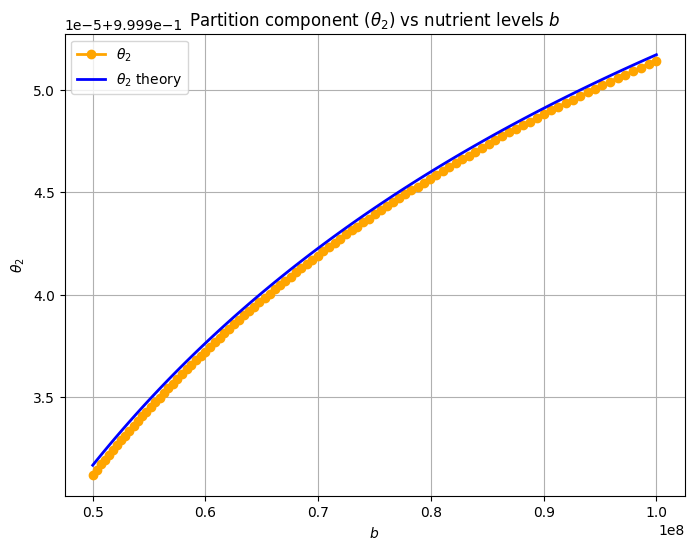

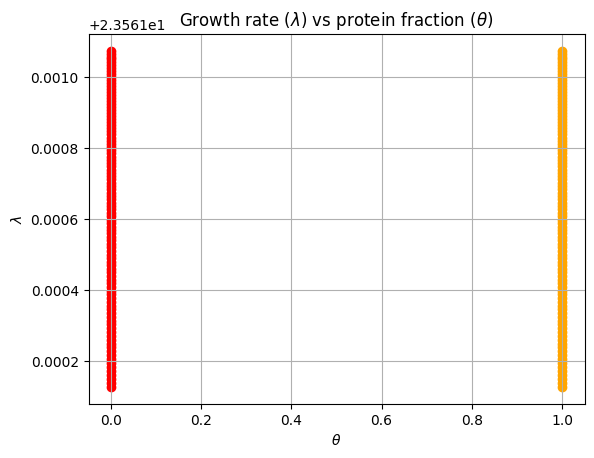

In [ ]:
# Approximate Theory
A = np.sqrt(k/a)

if b_large:
    theta1_approx_arr = (np.sqrt(k)/(1+k)) * np.sqrt(a/b_arr) - (k/(2*(1+k)**2)) * (np.sqrt(a/b_arr)**3)
    theta2_approx_arr = 1.0 - (np.sqrt(k)/(1+k)) * np.sqrt(a/b_arr) + (k/(2*(1+k)**2)) * (np.sqrt(a/b_arr)**3)
else:
    theta1_approx_arr = 1 - A*np.sqrt(b_arr) + (1/2)*A**3*b_arr**(3/2) - (3/8)*A**5*b_arr**(5/2) - (1/2)*(1 - 2*k)/a * b_arr
    theta2_approx_arr = np.sqrt(k/a)*( np.sqrt(b_arr) - (1/2)*A**2*b_arr**(3/2) + (3/8)*A**4*b_arr**(5/2) ) + (k/a)*b_arr

# Put in DataFrame
df = pd.DataFrame({
    "Nutrient level": b_arr,
    "Growth rate": lambda_arr,
    r"$\theta_1$": theta1_arr,
    r"$\theta_2$": theta2_arr,
    r"$p = \frac{\theta_2}{\theta_1}$": theta2_arr / theta1_arr,
    r"$\sum \theta$": theta1_arr + theta2_arr,
    r"Approx. $\sum \theta$": theta1_approx_arr + theta2_approx_arr
})

# Save to CSV file
df.to_csv('PP2_MM_output.csv', index=False, float_format='%.6f')
print(f"Data saved to PP2_MM_output.csv ({len(df)} rows)")

# Display first few rows
display(df.head(10))


# Partition components to nutrient levels b
plt.figure(figsize=(8,6))
plt.plot(b_arr, theta1_arr, lw=2, label=r'$\theta_1$', marker='o', color='red')
plt.plot(b_arr, theta2_arr, lw=2, label=r'$\theta_2$', marker='s', color='orange')
plt.plot(b_arr, theta1_approx_arr, lw=2, label=r'$\theta_1$', linestyle='-', color='red')
plt.plot(b_arr, theta2_approx_arr, lw=2, label=r'$\theta_2$', linestyle='-', color='orange')
plt.xlabel(r'$b$')
plt.ylabel(r'$\theta$')
plt.title(r'Partition components ($\theta$) vs nutrient levels $b$')
plt.grid(True)
plt.legend()
plt.show()

# Partition component theta1 to nutrient levels b
plt.figure(figsize=(8,6))
plt.plot(b_arr, theta1_arr, lw=2, label=r'$\theta_1$', marker='o', color='red')
plt.plot(b_arr, theta1_approx_arr, lw=2, label=r'$\theta_1$ theory', color='blue')
plt.xlabel(r'$b$'); plt.ylabel(r'$\theta_1$')
plt.title(r'Partition component ($\theta_1$) vs nutrient levels $b$')
plt.grid(True)
plt.legend()
plt.show()

# Partition component theta2 to nutrient levels b
plt.figure(figsize=(8,6))
plt.plot(b_arr, theta2_arr, lw=2, label=r'$\theta_2$', marker='o', color='orange')
plt.plot(b_arr, theta2_approx_arr, lw=2, label=r'$\theta_2$ theory', color='blue')
plt.xlabel(r'$b$'); plt.ylabel(r'$\theta_2$')
plt.title(r'Partition component ($\theta_2$) vs nutrient levels $b$')
plt.grid(True)
# plt.ylim(0.0, 0.01)
plt.legend()
plt.show()

# Growth rate to protein partition \theta
plt.figure()
plt.scatter(theta1_arr, lambda_arr, label=r'$\theta_1$', c='red')
plt.scatter(theta2_arr, lambda_arr, label=r'$\theta_2$', c='orange')
plt.xlabel(r'$\theta$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs protein fraction ($\theta$)')
plt.grid(True)
plt.show()

### Small and Large Molecules
The small molecules include metabolites and precursors. Large molecules include different types of proteins.

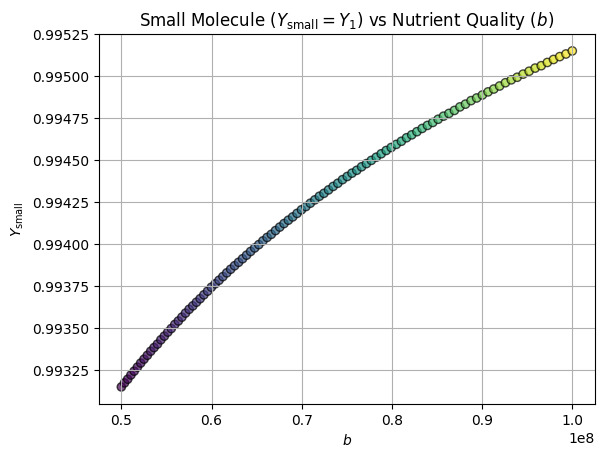

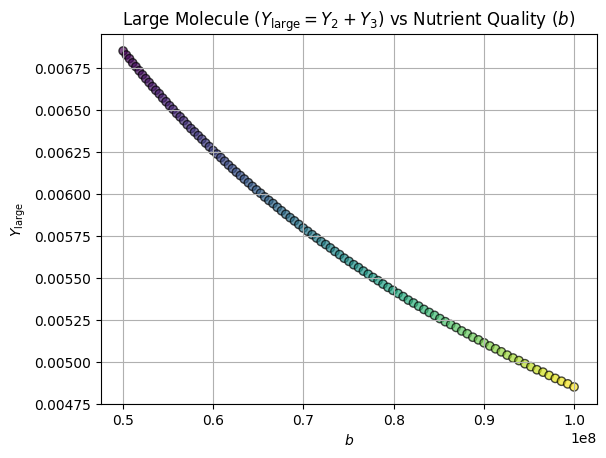

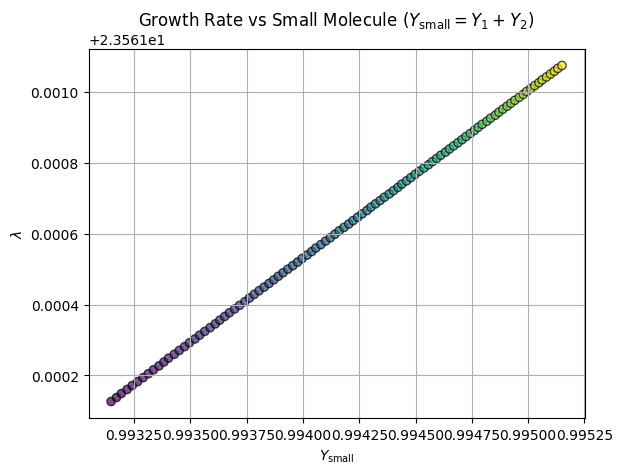

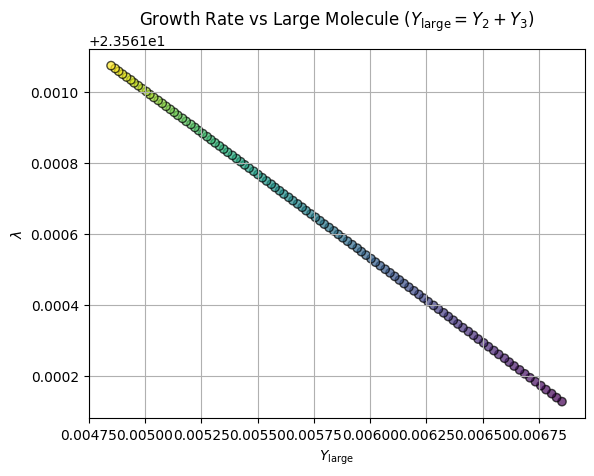

In [166]:
# Discuss different molecdule sizes
small_mol_arr = Y1_arr
large_mol_arr = Y2_arr + Y3_arr

# Small molecule (metabolites and a.a.'s) fraction (Y1 + Y2) to b
plt.figure()
scatter = plt.scatter(b_arr, small_mol_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.xlabel(r'$b$')
plt.ylabel(r'$Y_\text{small}$')
plt.title(r'Small Molecule ($Y_\text{small} = Y_1$) vs Nutrient Quality ($b$)')
plt.grid(True)
plt.show()

# Large molecule (proteins) fraction (Y3 + Y4 + Y5) to b
plt.figure()
scatter = plt.scatter(b_arr, large_mol_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.xlabel(r'$b$')
plt.ylabel(r'$Y_\text{large}$')
plt.title(r'Large Molecule ($Y_\text{large} = Y_2 + Y_3$) vs Nutrient Quality ($b$)')
plt.grid(True)
plt.show()

# Growth Rate vs Small Molecule fraction
plt.figure()
scatter = plt.scatter(small_mol_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.xlabel(r'$Y_\text{small}$')
plt.ylabel(r'$\lambda$')
plt.title(r'Growth Rate vs Small Molecule ($Y_\text{small} = Y_1 + Y_2$)')
plt.grid(True)
plt.show()

# Growth Rate vs large molecule fraction
plt.figure()
scatter = plt.scatter(large_mol_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.xlabel(r'$Y_\text{large}$')
plt.ylabel(r'$\lambda$')
plt.title(r'Growth Rate vs Large Molecule ($Y_\text{large} = Y_2 + Y_3$)')
plt.grid(True)
plt.show()